## Step 1. 실험환경 Set-up
Batch size, Epoch 등을 변경합니다.
## Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
이전 실습에서 고려하지 않았던 augmentation 기법을 고려합니다. (좌우반전)
## Step 3. 데이터 시각화
augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인합니다.
## Step 4. ResNet-18 구현
ResNet 가장 작은 버전인 ResNet-18로 구현합니다.
ResNet에서의 weight layer는 3x3 CNN, BatchNormalization, 활성화 함수 ReLU 로 구성됩니다.
Residual block을 구성했다면 이제는 아래 그림을 보고 ResNet을 구현해주세요 (참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿉니다.)
## Step 5. 데이터 imbalance 처리
imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을지 확인합니다.
## Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.
## Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석합니다


평가문항	상세기준
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.	모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.	regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
3. ResNet 모델을 구현 하였다	Resnet 의 Residual block을 구현하고 학습의 경우 1에폭만 진행하여도 인정

## 라이브러리 가져오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')
import tensorflow
import random
import math

print(tensorflow.__version__)

2.6.0


## 변수 생성
데이터를 열어보면 train, val(validation), test 로 나누어져 있게 된다.

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## 데이터 불러오기
train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있는 걸 확인할 수 있다.

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


## train과 val 분할
train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할한다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 체크해보기 위해 경로 체크를 한다.

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


파일 경로에 NORMAL이 있는지 확인하면 정상 이미지가 1070 있고 PNEUMONIA이 있는지 확인하면 폐렴 이미지가 3115 있는 걸 확인할 수 있다.
결과를 보면 정상보다 폐렴 이미지 수가 3배 많은데 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘한다.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


## tf.data 인스턴스 생성
tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할수 있도록 해준다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

## Train 및 validation dataset 개수 확인
train 이미지는 4185개고 validation 이미지는 1047개인 것을 확인할 수 있다.

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


## 라벨 데이터를 만들어주기
현재 이미지에는 라벨 데이터가 따로 없다. 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어준다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

## decode_img 함수와 process_path 함수 생성
process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경하고 get_label을 이용해서 라벨 값을 가져온다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

## Train 및 validation dataset 생성
num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리할 수 있어서 적용시킨다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해본다.

In [12]:
for image, label in train_ds.take(1): #train_ds.take(1):하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


## test dataset 생성
624개의 테스트 데이터가 있는 걸 확인할 수 있다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## tf.data 파이프라인을 이용하여 데이터를 변환
Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다. 
shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택하고 repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다. 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰주게 된다.
batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다. 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 된다.
prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 좌우 반전 augmentation 적용
의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문이다. 그래서 augmentation 도입은 신중해야한다.

도저히 주어진 좌우 반전 augmentation 코드로는 진행이 되지 않아 따로 생성해서 진행했다..

In [15]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image, label

# prepare_for_training 함수 수정
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment,  # augment 함수 적용
        num_parallel_calls=AUTOTUNE
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


# Step 3. 데이터 시각화

원본 이미지와 augment된 이미지를 시각화 함수로 정의한다.

In [16]:
def visualize(original_img, augmented_img):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_img)

    plt.subplot(1, 2, 2)
    plt.title('Augmented Image')
    plt.imshow(augmented_img)

    plt.show()

좌우 반전 augmentation된 사진을 한번 확인해보자.

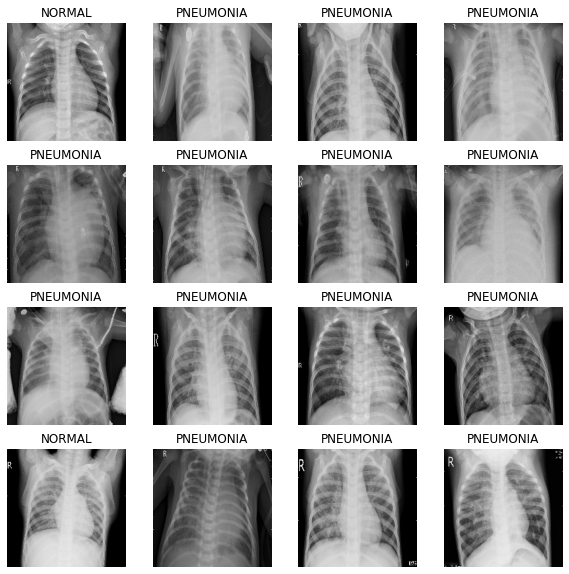

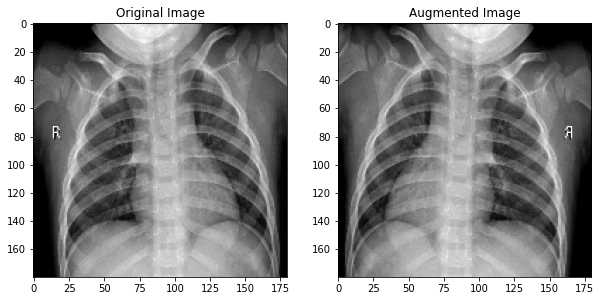

In [17]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(len(image_batch)):
        ax = plt.subplot(4, math.ceil(len(image_batch) / 4), n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

# train_ds에서 이미지 배치 가져오기
image_batch, label_batch = next(iter(train_ds))

# 시각화 함수 호출
show_batch(image_batch.numpy(), label_batch.numpy())

# 시각화를 위해 원본 이미지와 augment된 이미지 한 쌍을 추출
for image, label in train_ds.take(1):
    augmented_image = augment(image, label)[0].numpy()
    visualize(image[0], augmented_image[0])

# Step 4. ResNet-18 구현

## 레이어 정의

In [18]:
from tensorflow.keras import layers, models

# 입력 레이어 정의
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)  # 이미지 크기와 컬러 채널 수
input_layer = layers.Input(shape=input_shape)

# 맥스 풀링 레이어 정의
x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(input_layer)


## Residual block 생성
첫 번째 Convolutional Layer와 두 번째 Convolutional Layer가 있고, 그 뒤에 Shortcut Connection 및 Skip Connection(Residual Connection)이 이어지는 기본적인 residual blcok 구조를 만들어준다.

In [19]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # 첫 번째 Convolutional Layer
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    # 두 번째 Convolutional Layer
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)

    # Shortcut Connection
    if stride != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='valid')(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x

    # Skip Connection (Residual Connection)
    y = layers.add([y, shortcut])
    y = layers.Activation('relu')(y)
    return y


## ResNet-18 모델 구성


In [20]:
# ResNet-18 모델 구성
def build_resnet18(input_shape, num_classes):
    # 초기 Convolutional Layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Residual Blocks
    x = residual_block(x, filters=64, stride=1)
    x = residual_block(x, filters=64, stride=1)
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128, stride=1)
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256, stride=1)
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512, stride=1)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(1, activation='sigmoid')(x)  # num_classes를 1로 변경하고, activation을 'sigmoid'로 변경

    # 모델 생성
    model = models.Model(inputs=input_layer, outputs=x)
    
    return model

# ResNet-18 모델 생성
num_classes = 2  # "NORMAL" 또는 "PNEUMONIA"
resnet18_model = build_resnet18(input_shape, num_classes)

# 모델 구조 출력
resnet18_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 90, 90, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

에폭은 3 배치사이즈는 32로 정해주고 모델을 컴파일 하고 학습을 설정해준다.

# Step 6. 모델 훈련

In [21]:
# 새로운 BATCH_SIZE와 EPOCHS 값 지정
BATCH_SIZE = 32
EPOCHS = 3

# 모델 컴파일
resnet18_model.compile(optimizer='adam', 
                       loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Early Stopping 및 Model Checkpoint 설정
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'resnet18_model.h5',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# 학습 설정
history = resnet18_model.fit(train_ds,
                             epochs=EPOCHS,
                             steps_per_epoch=len(train_filenames)//BATCH_SIZE,
                             validation_data=val_ds,
                             validation_steps=len(val_filenames)//BATCH_SIZE,
                             callbacks=[early_stopping, model_checkpoint])


Epoch 1/3
130/130 [==============================] - 43s 235ms/step - loss: 0.3310 - accuracy: 0.8813 - precision: 0.9124 - recall: 0.9305 - val_loss: 6.1980 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 6.19801, saving model to resnet18_model.h5
Epoch 2/3
130/130 [==============================] - 29s 225ms/step - loss: 0.1884 - accuracy: 0.9236 - precision: 0.9414 - recall: 0.9566 - val_loss: 0.7119 - val_accuracy: 0.7734 - val_precision: 0.7647 - val_recall: 1.0000

Epoch 00002: val_loss improved from 6.19801 to 0.71193, saving model to resnet18_model.h5
Epoch 3/3
130/130 [==============================] - 30s 233ms/step - loss: 0.1440 - accuracy: 0.9447 - precision: 0.9592 - recall: 0.9672 - val_loss: 3.0033 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 1.0000

Epoch 00003: val_loss did not improve from 0.71193


# Step 7. 결과 확인과 시각화

Loss: 2.7661 Accuracy: 0.7539 Precision: 0.7539 Recall: 1.0000 결과가 나왔다..

In [22]:
# 최종 결과 출력
final_metrics = resnet18_model.evaluate(val_ds, steps=len(val_filenames)//BATCH_SIZE)
print("Final Metrics on Validation Set:")
print(f" - Loss: {final_metrics[0]:.4f}")
print(f" - Accuracy: {final_metrics[1]:.4f}")
print(f" - Precision: {final_metrics[2]:.4f}")
print(f" - Recall: {final_metrics[3]:.4f}")

32/32 [==============================] - 12s 129ms/step - loss: 2.7661 - accuracy: 0.7539 - precision: 0.7539 - recall: 1.0000
Final Metrics on Validation Set:
 - Loss: 2.7661
 - Accuracy: 0.7539
 - Precision: 0.7539
 - Recall: 1.0000


굉장히 불안정한 결과로 보여진다..

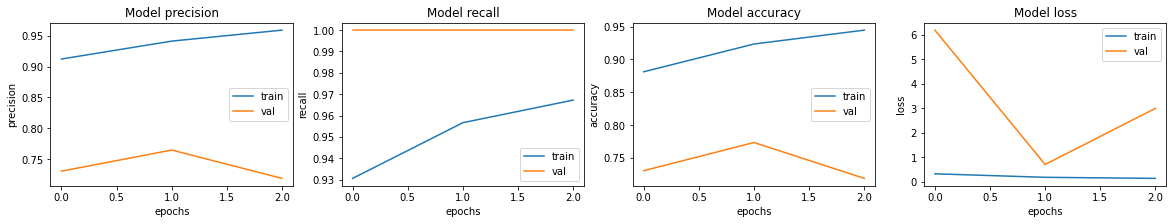

In [23]:
# 결과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    if met in history.history:
        ax[i].plot(history.history[met])
        if 'val_' + met in history.history:
            ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

plt.show()


이번엔 class_weight 가중치를 적용시키고 학습시켜볼 것이다.

In [24]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# train 데이터셋에서 라벨 추출
train_labels = np.array([get_label(file_path) for file_path in train_filenames])

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}



다시 모델을 그대로 가져온다.

In [25]:
# ResNet-18 모델 구성
def build_resnet18(input_shape, num_classes):
    # 초기 Convolutional Layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Residual Blocks
    x = residual_block(x, filters=64, stride=1)
    x = residual_block(x, filters=64, stride=1)
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128, stride=1)
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256, stride=1)
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512, stride=1)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer (Dense Layer)
    x = layers.Dense(1, activation='sigmoid')(x)  # num_classes를 1로 변경하고, activation을 'sigmoid'로 변경

    # 모델 생성
    model = models.Model(inputs=input_layer, outputs=x)
    
    return model

# ResNet-18 모델 생성
num_classes = 2  # "NORMAL" 또는 "PNEUMONIA"
resnet18_model = build_resnet18(input_shape, num_classes)

# 모델 컴파일
resnet18_model.compile(optimizer='adam', 
                       loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Early Stopping 및 Model Checkpoint 설정
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'resnet18_model.h5',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)


비교를 위해 에폭 3 배치사이즈 32 그대로 주고 학습시켜본다.

In [26]:
EPOCHS = 3
BATCH_SIZE = 32

# 학습 설정
history = resnet18_model.fit(train_ds,
                             epochs=EPOCHS,
                             steps_per_epoch=len(train_filenames)//BATCH_SIZE,
                             validation_data=val_ds,
                             validation_steps=len(val_filenames)//BATCH_SIZE,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weight)

Epoch 1/3
130/130 [==============================] - 41s 239ms/step - loss: 0.3757 - accuracy: 0.8548 - precision: 0.9503 - recall: 0.8500 - val_loss: 4.5036 - val_accuracy: 0.7402 - val_precision: 0.7402 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 4.50364, saving model to resnet18_model.h5
Epoch 2/3
130/130 [==============================] - 29s 227ms/step - loss: 0.2143 - accuracy: 0.9106 - precision: 0.9715 - recall: 0.9060 - val_loss: 2.8634 - val_accuracy: 0.7090 - val_precision: 0.7090 - val_recall: 1.0000

Epoch 00002: val_loss improved from 4.50364 to 2.86341, saving model to resnet18_model.h5
Epoch 3/3
130/130 [==============================] - 30s 234ms/step - loss: 0.1834 - accuracy: 0.9264 - precision: 0.9755 - recall: 0.9246 - val_loss: 0.7110 - val_accuracy: 0.7051 - val_precision: 1.0000 - val_recall: 0.6026

Epoch 00003: val_loss improved from 2.86341 to 0.71101, saving model to resnet18_model.h5


Loss: 0.8792 Accuracy: 0.3828 Precision: 1.0000 Recall: 0.1222 이 나왔다. precision이 1이라니? accuracy가 0.3인데 결과가 너무 극단적이라 이걸 좋아진거라고 할 수 있는걸지 모르겠다..

In [27]:
# 최종 결과 출력
final_metrics = resnet18_model.evaluate(val_ds, steps=len(val_filenames)//BATCH_SIZE)
print("Final Metrics on Validation Set:")
print(f" - Loss: {final_metrics[0]:.4f}")
print(f" - Accuracy: {final_metrics[1]:.4f}")
print(f" - Precision: {final_metrics[2]:.4f}")
print(f" - Recall: {final_metrics[3]:.4f}")

32/32 [==============================] - 12s 128ms/step - loss: 0.6995 - accuracy: 0.7070 - precision: 0.9953 - recall: 0.5884
Final Metrics on Validation Set:
 - Loss: 0.6995
 - Accuracy: 0.7070
 - Precision: 0.9953
 - Recall: 0.5884


여전히 불안정해보인다..

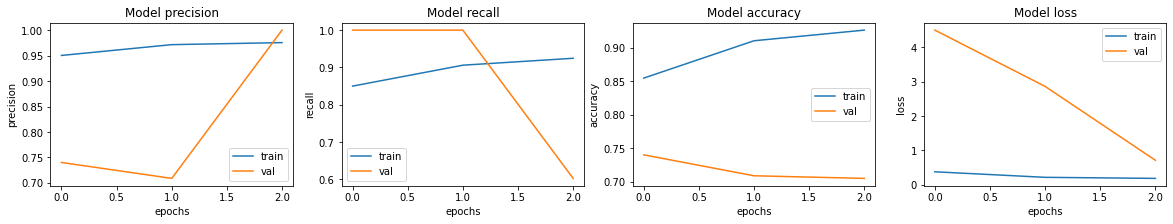

In [28]:
# 결과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    if met in history.history:
        ax[i].plot(history.history[met])
        if 'val_' + met in history.history:
            ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

plt.show()


## optimizer로 변경

optimizer로 변경만 하고 그대로 에폭3에 배치사이즈 32로 학습시켜본다.

In [30]:
optimizer = tf.keras.optimizers.Adam()
resnet18_model.compile(optimizer=optimizer, 
                       loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Early Stopping 및 Model Checkpoint 설정
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'resnet18_model.h5',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [31]:
EPOCHS = 3
BATCH_SIZE = 32

# 학습 설정
history = resnet18_model.fit(train_ds,
                             epochs=EPOCHS,
                             steps_per_epoch=len(train_filenames)//BATCH_SIZE,
                             validation_data=val_ds,
                             validation_steps=len(val_filenames)//BATCH_SIZE,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weight)

Epoch 1/3
130/130 [==============================] - 40s 235ms/step - loss: 0.2325 - accuracy: 0.9135 - precision: 0.9706 - recall: 0.9121 - val_loss: 21.7149 - val_accuracy: 0.2812 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_loss improved from inf to 21.71487, saving model to resnet18_model.h5
Epoch 2/3
130/130 [==============================] - 29s 224ms/step - loss: 0.1882 - accuracy: 0.9250 - precision: 0.9745 - recall: 0.9225 - val_loss: 3.5287 - val_accuracy: 0.3145 - val_precision: 1.0000 - val_recall: 0.0277

Epoch 00002: val_loss improved from 21.71487 to 3.52875, saving model to resnet18_model.h5
Epoch 3/3
130/130 [==============================] - 30s 232ms/step - loss: 0.1448 - accuracy: 0.9438 - precision: 0.9820 - recall: 0.9425 - val_loss: 0.2839 - val_accuracy: 0.8730 - val_precision: 0.8815 - val_recall: 0.9545

Epoch 00003: val_loss improved from 3.52875 to 0.28386, saving model to resnet18_model.h5


Loss: 0.2891 Accuracy: 0.8711 Precision: 0.8700 Recall: 0.9613 뭔가 수치로 봤을 땐 여태 제일 베스트 결과가 아닌가 싶다.

In [32]:
# 최종 결과 출력
final_metrics = resnet18_model.evaluate(val_ds, steps=len(val_filenames)//BATCH_SIZE)
print("Final Metrics on Validation Set:")
print(f" - Loss: {final_metrics[0]:.4f}")
print(f" - Accuracy: {final_metrics[1]:.4f}")
print(f" - Precision: {final_metrics[2]:.4f}")
print(f" - Recall: {final_metrics[3]:.4f}")

32/32 [==============================] - 12s 133ms/step - loss: 0.2891 - accuracy: 0.8711 - precision: 0.8700 - recall: 0.9613
Final Metrics on Validation Set:
 - Loss: 0.2891
 - Accuracy: 0.8711
 - Precision: 0.8700
 - Recall: 0.9613


그래프는 여전히 난동을 친다.. recall과 loss는 잘 수렴해가는 것 같다..

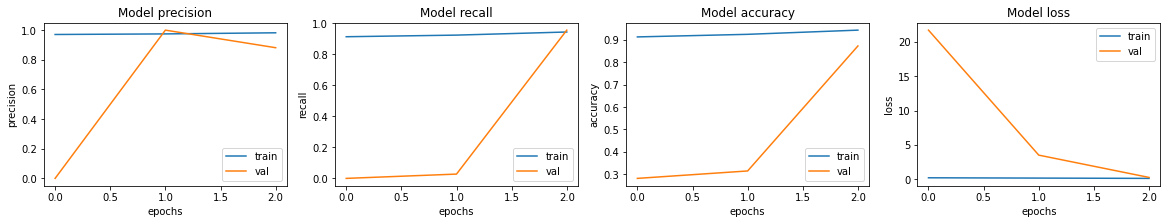

In [33]:
# 결과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    if met in history.history:
        ax[i].plot(history.history[met])
        if 'val_' + met in history.history:
            ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

plt.show()


# Learning Rate를 변경

그대로 여기에 learning rate를 0.005를 주고 다시 학습시켜본다.

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
resnet18_model.compile(optimizer=optimizer, 
                       loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Early Stopping 및 Model Checkpoint 설정
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'resnet18_model.h5',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [35]:
EPOCHS = 3
BATCH_SIZE = 32

# 학습 설정
history = resnet18_model.fit(train_ds,
                             epochs=EPOCHS,
                             steps_per_epoch=len(train_filenames)//BATCH_SIZE,
                             validation_data=val_ds,
                             validation_steps=len(val_filenames)//BATCH_SIZE,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weight)

Epoch 1/3
130/130 [==============================] - 40s 238ms/step - loss: 0.4153 - accuracy: 0.8476 - precision: 0.9378 - recall: 0.8547 - val_loss: 39.4144 - val_accuracy: 0.2910 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_loss improved from inf to 39.41441, saving model to resnet18_model.h5
Epoch 2/3
130/130 [==============================] - 29s 225ms/step - loss: 0.2099 - accuracy: 0.9168 - precision: 0.9701 - recall: 0.9148 - val_loss: 17.0086 - val_accuracy: 0.2656 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_loss improved from 39.41441 to 17.00864, saving model to resnet18_model.h5
Epoch 3/3
130/130 [==============================] - 30s 232ms/step - loss: 0.1865 - accuracy: 0.9288 - precision: 0.9756 - recall: 0.9277 - val_loss: 2.6210 - val_accuracy: 0.4062 - val_precision: 1.0000 - val_recall: 0.1806

Epoch 00003: val_loss improved from 17.00864 to 2.62100, saving model to resnet18_model.h5


Loss: 2.8570 Accuracy: 0.3828 Precision: 1.0000 Recall: 0.1505 결과가 다시 극단적으로 바꼈다.. 특히 loss값이 너무 높아져버렸다..

In [36]:
# 최종 결과 출력
final_metrics = resnet18_model.evaluate(val_ds, steps=len(val_filenames)//BATCH_SIZE)
print("Final Metrics on Validation Set:")
print(f" - Loss: {final_metrics[0]:.4f}")
print(f" - Accuracy: {final_metrics[1]:.4f}")
print(f" - Precision: {final_metrics[2]:.4f}")
print(f" - Recall: {final_metrics[3]:.4f}")

32/32 [==============================] - 12s 143ms/step - loss: 2.8570 - accuracy: 0.3828 - precision: 1.0000 - recall: 0.1505
Final Metrics on Validation Set:
 - Loss: 2.8570
 - Accuracy: 0.3828
 - Precision: 1.0000
 - Recall: 0.1505


전과는 다르게 precision과 loss값이 수렴해가는 것을 볼 수 있다.

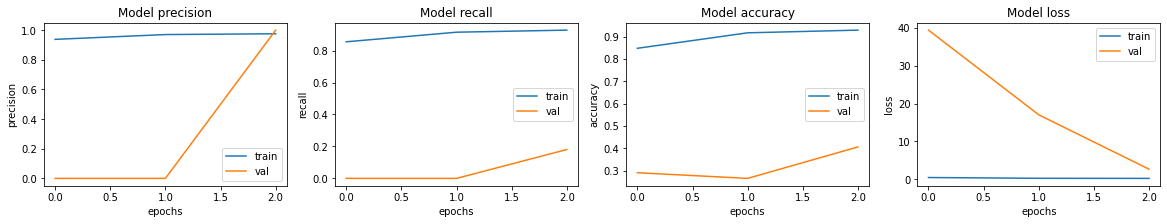

In [37]:
# 결과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    if met in history.history:
        ax[i].plot(history.history[met])
        if 'val_' + met in history.history:
            ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

plt.show()


# 에폭6 배치사이즈를 64로 증가

에폭과 배치사이즈를 두배로 늘리고 그대로 다시 학습시켜본다.

In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
resnet18_model.compile(optimizer=optimizer, 
                       loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Early Stopping 및 Model Checkpoint 설정
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'resnet18_model.h5',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [39]:
EPOCHS = 3
BATCH_SIZE = 32

# 학습 설정
history = resnet18_model.fit(train_ds,
                             epochs=EPOCHS,
                             steps_per_epoch=len(train_filenames)//BATCH_SIZE,
                             validation_data=val_ds,
                             validation_steps=len(val_filenames)//BATCH_SIZE,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weight)

Epoch 1/3
130/130 [==============================] - 40s 236ms/step - loss: 0.2476 - accuracy: 0.9043 - precision: 0.9670 - recall: 0.9030 - val_loss: 2.8538 - val_accuracy: 0.5371 - val_precision: 1.0000 - val_recall: 0.3860

Epoch 00001: val_loss improved from inf to 2.85381, saving model to resnet18_model.h5
Epoch 2/3
130/130 [==============================] - 29s 225ms/step - loss: 0.1659 - accuracy: 0.9356 - precision: 0.9802 - recall: 0.9317 - val_loss: 0.3917 - val_accuracy: 0.8906 - val_precision: 0.9938 - val_recall: 0.8556

Epoch 00002: val_loss improved from 2.85381 to 0.39172, saving model to resnet18_model.h5
Epoch 3/3
130/130 [==============================] - 30s 233ms/step - loss: 0.1432 - accuracy: 0.9428 - precision: 0.9832 - recall: 0.9395 - val_loss: 10.7327 - val_accuracy: 0.2793 - val_precision: 1.0000 - val_recall: 0.0054

Epoch 00003: val_loss did not improve from 0.39172


Loss: 10.8422 Accuracy: 0.2656 Precision: 1.0000 Recall: 0.0079 이 결과는 최악인게 아닐까.. loss값은 10이 넘었고 recall은 엄청 낮아졌다.

In [40]:
# 최종 결과 출력
final_metrics = resnet18_model.evaluate(val_ds, steps=len(val_filenames)//BATCH_SIZE)
print("Final Metrics on Validation Set:")
print(f" - Loss: {final_metrics[0]:.4f}")
print(f" - Accuracy: {final_metrics[1]:.4f}")
print(f" - Precision: {final_metrics[2]:.4f}")
print(f" - Recall: {final_metrics[3]:.4f}")

32/32 [==============================] - 12s 133ms/step - loss: 10.8422 - accuracy: 0.2656 - precision: 1.0000 - recall: 0.0079
Final Metrics on Validation Set:
 - Loss: 10.8422
 - Accuracy: 0.2656
 - Precision: 1.0000
 - Recall: 0.0079


그래프도 역시 모든면에서 최악으로 나왔다..

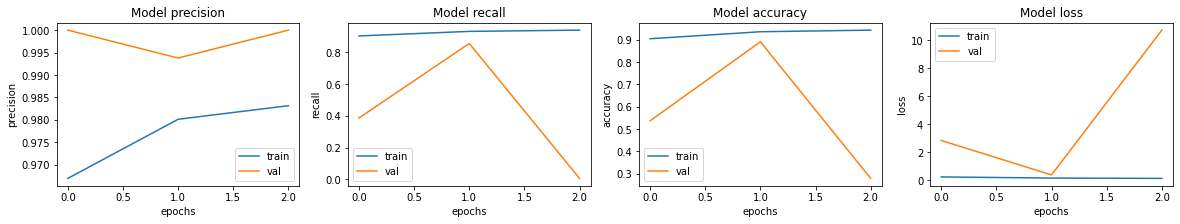

In [41]:
# 결과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    if met in history.history:
        ax[i].plot(history.history[met])
        if 'val_' + met in history.history:
            ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

plt.show()

# 회고


## 서론

병원에서 사용되는 X-RAY 사진 판독 폐렴 진단기를 만들어 다양한 모델 훈련을 해보면서 성능을 개선시키는 프로젝트이다.

## 개발 과정

원본 X-RAY 사진데이터들을 가져와서 전처리 및 배치 구성을 진행 후 좌우 반전 ugmentation 기법을 추가하고 show_batch()를 사용하여 잘 적용됐는지 데이터 시각화를 한다. 그리고 심층 신경망 아키텍처 중 하나인 ResNet-18 구현을 위해 첫 번째 Convolutional Layer와 두 번째 Convolutional Layer가 있고, 그 뒤에 Shortcut Connection 및 Skip Connection(Residual Connection)이 이어지는 기본적인 residual blcok 구조를 만들어준다. 모델을 컴파일하고 Loss, Accuracy, Precision 그리고 Recall 값을 측정하고 그래프로 시각화하여 결과를 비교해본다. 추가로 optimizer로 변경해보고 learning_rate를 설정해보고 epoch값과 batch size값을 변경해가면서 다시 결과를 확인 및 비교해보았다.

## 결과 및 토론

여러가지의 방법으로 결과를 비교해봤지만 원하는 완벽한 결과는 나오지 않았고 어떤 하이퍼파라미터 값에 의해 성능이 개선되는 건지에 대해 더 테스트해보고 싶었으나 좌우 반전 augmentation을 적용시키는데에 있어서 너무 많은 시간을 소비해서 큰 에폭값으로 실험을 해볼 시간이 없었다. 해봤던 결과들 중에 다른 종류의 알고리즘인 optimizer로 변경 후 epoch값을 3 batch size값을 32로 줬을 때가 제일 나은 결과가 아니였나 싶다. 



## 배운 점 및 회고

Resnet-18 모델을 직접 만들고 훈련시켜보면서 조금 더 코드를 구현하는데에 익숙해진 것 같다. 하지만 augmentation을 적용시키는 것과 convolutional layer를 쌓는 부분에 어려움이 있어서 확인이 필요했었다. 그리고 환자의 폐 상태나 위치에 대해 완벽하게 정확하게 확인하기 위해서는 augmentation을 적용시켰을 때 좌우 반전이 됐을 경우 오히려 학습에 문제가 더 생겨서 적용을 시키지 않는게 더 낫지 않을까 하는 의문이 있었다. 또한 어떠한 하이퍼파라미터와 어떠한 최적화 알고리즘을 사용했을 때 좋은 결과가 나오는 지 테스트해 볼 시간이 없어서 아쉬움이 많이 남았다.


## 레퍼런스
https://mvje.tistory.com/51
https://dnddnjs.github.io/cifar10/2018/10/09/resnet/
https://velog.io/@bbiyak807/DL-ResNet-%EA%B8%B0%EC%B4%88ResNet18
